In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, make_scorer, recall_score, precision_score, accuracy_score
from helper import wrap_labels

In [2]:
df = pd.read_csv('data/final_data.csv', sep=',')

In [3]:
df = df.drop(["Unnamed: 0"], axis=1)

In [4]:
#Factorizing Full Time Result column so it can be fit into machine learning algorithms
df['Full Time Result'] = pd.factorize(df['Full Time Result'])[0]

Factorizing result:
Home win = 0
Draw = 1
Away win = 2

# Machine Learning  Baseline Models

In [5]:
# Test train data split
X = df.drop("Full Time Result", axis=1)
y = df["Full Time Result"]
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=42)

In [6]:
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='weighted'),
                 'recall': make_scorer(recall_score, average='weighted'),
                 }

### Naive bayes model

In [36]:
np.random.seed(42)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

print(classification_report(y_test, y_pred_gnb))
gnb_report = classification_report(y_test, y_pred_gnb, output_dict=True)
cv_gnb = cross_validate(gnb, X, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.71      0.74      0.72       247
           1       0.34      0.40      0.37       110
           2       0.70      0.58      0.64       175

    accuracy                           0.62       532
   macro avg       0.58      0.57      0.58       532
weighted avg       0.63      0.62      0.62       532



### Decision tree model

In [8]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

print(classification_report(y_test, y_pred_dtc))
cv_dtc = cross_validate(dtc, X, y, cv=5, scoring=custom_scorer)


              precision    recall  f1-score   support

           0       0.67      0.68      0.68       247
           1       0.28      0.38      0.32       110
           2       0.57      0.42      0.48       175

    accuracy                           0.53       532
   macro avg       0.51      0.49      0.49       532
weighted avg       0.56      0.53      0.54       532



### Random forest model

In [9]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_test, y_pred_rfc))
cv_rfc = cross_validate(rfc, X, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.69      0.87      0.77       247
           1       0.38      0.27      0.32       110
           2       0.73      0.59      0.65       175

    accuracy                           0.66       532
   macro avg       0.60      0.58      0.58       532
weighted avg       0.64      0.66      0.64       532



### Logistic Regression model

In [10]:
lr = LogisticRegression(multi_class='auto', solver='newton-cg', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cv_lr=cross_validate(lr, X, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.71      0.88      0.78       247
           1       0.47      0.33      0.39       110
           2       0.76      0.65      0.70       175

    accuracy                           0.69       532
   macro avg       0.65      0.62      0.62       532
weighted avg       0.68      0.69      0.67       532



### KNN model with normalization

In [11]:
X_normalized = sklearn.preprocessing.normalize(X, norm='l2')
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
X_normalized, y, test_size=0.20, random_state=42)

In [12]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_n,y_train_n)
y_pred_knn = knn.predict(X_test_n)
print(classification_report(y_test_n, y_pred_knn))
cv_knn = cross_validate(knn, X_normalized, y, cv=5, scoring=custom_scorer)

              precision    recall  f1-score   support

           0       0.60      0.79      0.69       247
           1       0.21      0.15      0.18       110
           2       0.58      0.42      0.49       175

    accuracy                           0.54       532
   macro avg       0.47      0.46      0.45       532
weighted avg       0.51      0.54      0.52       532



## Base Model comparison

In [13]:
# Replacing all cross-validation scores for all models with a mean of that score
cvs = [cv_gnb, cv_dtc, cv_rfc, cv_lr, cv_knn]
for cv in cvs:
    for key in cv.keys():
        cv[key] = round(np.mean(cv[key]),2)

In [14]:
# Creating dictionaries for precision, recall and accuracy where key = model name, value = mean
labels = ['Naive Bayes', 'Decision Tree', 'Random Forest','Logistic Regression', 'KNN']
avg_precision = {}
avg_recall = {}
avg_accuracy = {}
for cv,label in zip(cvs,labels):
    avg_precision[label] = cv['test_precision']
    avg_accuracy[label] = cv['test_accuracy']
    avg_recall[label] = cv['test_recall']

### Accuracy

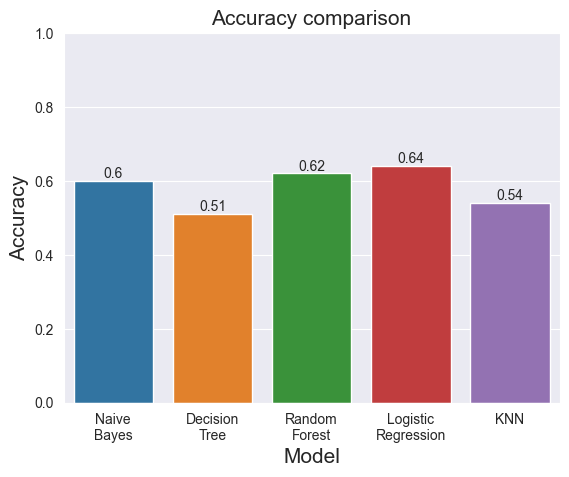

In [15]:
ax = sns.barplot(x=list(avg_accuracy.keys()), y=list(avg_accuracy.values()))
for i in ax.containers:
    ax.bar_label(i,)

plt.ylim(0.0,1.0)
plt.title("Accuracy comparison",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
wrap_labels(ax, 10)

### Precision

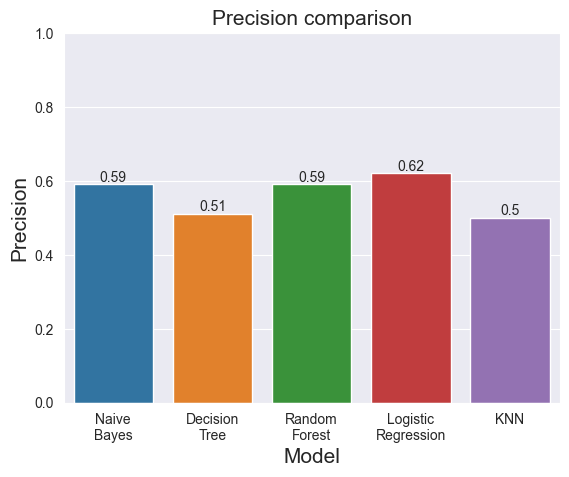

In [16]:
ax = sns.barplot(x=list(avg_precision.keys()), y=list(avg_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Precision comparison",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

### Recall

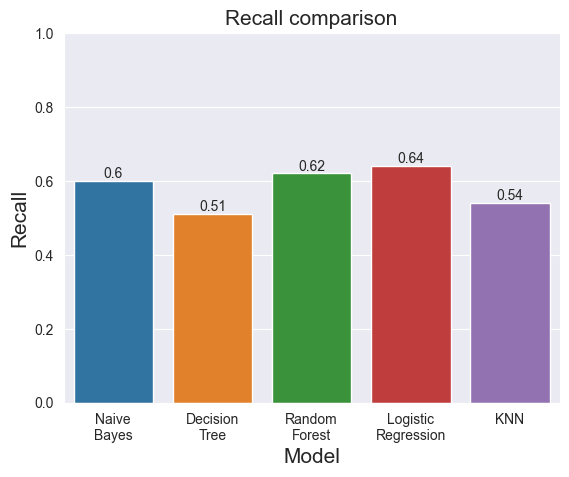

In [17]:
ax = sns.barplot(x=list(avg_recall.keys()), y=list(avg_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Recall comparison",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Recall",fontsize=15)
wrap_labels(ax, 10)

# Tuning Hyperparameters

### Decision Tree tuning

In [18]:
dtc_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5,10,20,30],
    'min_samples_split': [2,3,4],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [42]
} # final iteration of grid search params that resulted with finding the best score

dtc = DecisionTreeClassifier()
gs_dtc = GridSearchCV(estimator=dtc, param_grid=dtc_params,cv=5)

gs_dtc.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4], 'random_state': [42]})

In [19]:
gs_dtc.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'min_samples_split': 2,
 'random_state': 42}

In [29]:
gs_y_pred = gs_dtc.predict(X_test)
print(classification_report(y_test, gs_y_pred))
dtc_report = classification_report(y_test, gs_y_pred,output_dict=True)

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       247
           1       0.43      0.29      0.35       110
           2       0.65      0.62      0.63       175

    accuracy                           0.65       532
   macro avg       0.60      0.58      0.58       532
weighted avg       0.63      0.65      0.64       532



### Random Forest Tuning

In [21]:
rfc_params ={
    'n_estimators': [500],
    'criterion': ['entropy','gini'],
    'max_depth': [None,5,10,15],
    'min_samples_split': [2,3,4],
    'max_features': ['sqrt'],
    'random_state': [42]
} # final iteration of grid search params that resulted in finding the best score
rfc = RandomForestClassifier()
gs_rfc = GridSearchCV(estimator=rfc,param_grid=rfc_params,cv=5)
gs_rfc.fit(X_train,y_train)
gs_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 3,
 'n_estimators': 500,
 'random_state': 42}

In [30]:
rfc_y_pred = gs_rfc.predict(X_test)
print(classification_report(y_test,rfc_y_pred))
rfc_report = classification_report(y_test,rfc_y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       247
           1       0.39      0.22      0.28       110
           2       0.72      0.63      0.67       175

    accuracy                           0.66       532
   macro avg       0.60      0.58      0.57       532
weighted avg       0.64      0.66      0.64       532



### Logistic Regression Tuning

In [24]:
lr_params = {
    'penalty': [None, 'l2'],
    'solver': ['newton-cg', 'sag', 'saga'],
    'max_iter': [3000],
    'multi_class': ['auto'],
    'random_state': [42]
} # final iteration of grid search params that resulted in finding the best score
lr = LogisticRegression()
gs_lr = GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, verbose=1)
gs_lr.fit(X_train, y_train)
gs_lr.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'max_iter': 3000,
 'multi_class': 'auto',
 'penalty': None,
 'random_state': 42,
 'solver': 'sag'}

In [31]:
lr_y_pred = gs_lr.predict(X_test)
print(classification_report(y_test,lr_y_pred))
lr_report =  classification_report(y_test,lr_y_pred,output_dict=True)

              precision    recall  f1-score   support

           0       0.71      0.87      0.79       247
           1       0.47      0.33      0.39       110
           2       0.76      0.66      0.70       175

    accuracy                           0.69       532
   macro avg       0.65      0.62      0.62       532
weighted avg       0.68      0.69      0.68       532



### KNN Tuning

In [27]:
knn_params ={
    'n_neighbors': [25,30,35,40,45,50],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'p': [1,2]
} # final iteration of grid search params that resulted in finding the best score
knn = KNeighborsClassifier()
gs_knn = GridSearchCV(estimator=knn, param_grid=knn_params, verbose=1)
gs_knn.fit(X_train_n, y_train_n)
gs_knn.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'algorithm': 'ball_tree', 'n_neighbors': 45, 'p': 1, 'weights': 'distance'}

In [32]:
knn_y_pred = gs_knn.predict(X_test_n)
print(classification_report(y_test_n,knn_y_pred))
knn_report = classification_report(y_test_n,knn_y_pred, output_dict=True)

              precision    recall  f1-score   support

           0       0.61      0.83      0.70       247
           1       0.26      0.15      0.19       110
           2       0.58      0.43      0.50       175

    accuracy                           0.56       532
   macro avg       0.48      0.47      0.46       532
weighted avg       0.53      0.56      0.53       532



# Tuned models comparison

In [43]:
reports = [gnb_report, dtc_report, rfc_report,lr_report,knn_report]

c0_precision = {}
c1_precision = {}
c2_precision = {}

c0_recall = {}
c1_recall = {}
c2_recall = {}

tuned_accuracy = {}
for report,label in zip(reports, labels):
    c0_precision[label] = round(report['0']['precision'],2)
    c1_precision[label] = round(report['1']['precision'],2)
    c2_precision[label] = round(report['2']['precision'],2)
    c0_recall[label] = round(report['0']['recall'],2)
    c1_recall[label] = round(report['1']['recall'],2)
    c2_recall[label] = round(report['2']['recall'],2)
    tuned_accuracy[label] = round(report['accuracy'],2)

## Class 0 - Home Win  analysis

### Precision

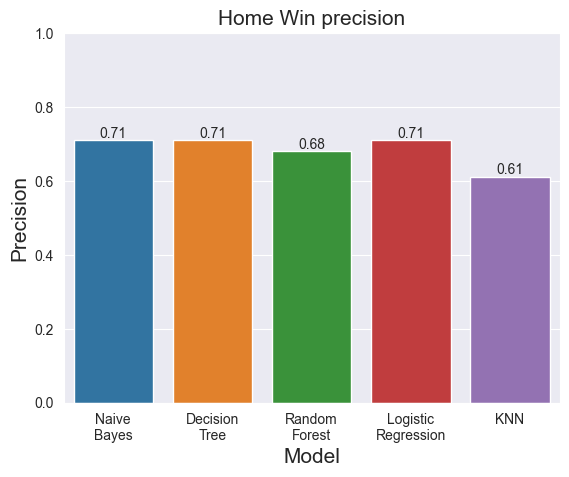

In [55]:
ax = sns.barplot(x=list(c0_precision.keys()), y=list(c0_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Home Win precision",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

### Recall

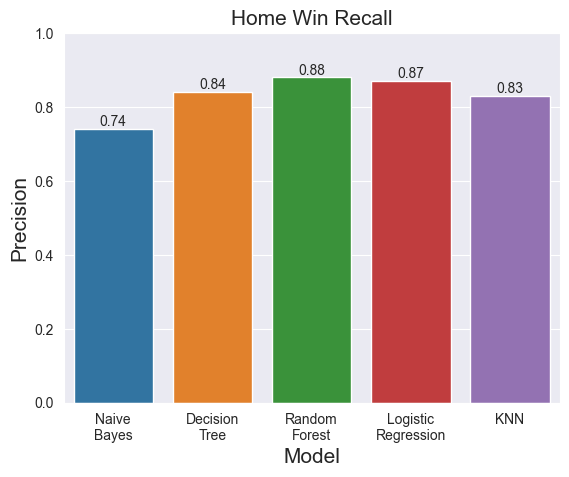

In [56]:
ax = sns.barplot(x=list(c0_recall.keys()), y=list(c0_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Home Win Recall",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

## Class 1 - Draw analysis

### Precision

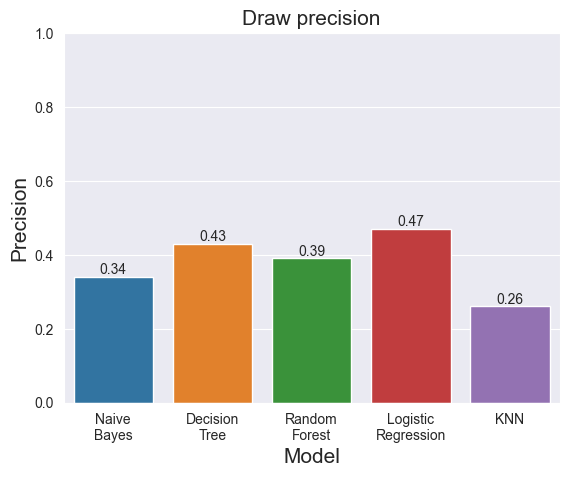

In [53]:
ax = sns.barplot(x=list(c1_precision.keys()), y=list(c1_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Draw precision",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

### Recall

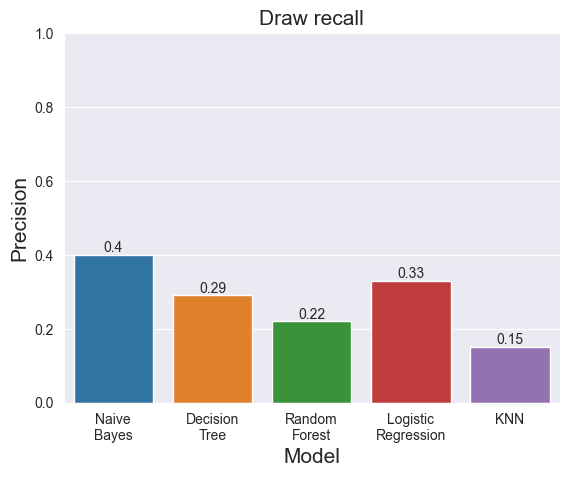

In [57]:
ax = sns.barplot(x=list(c1_recall.keys()), y=list(c1_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Draw recall",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

## Class 2 - Away win analysis

### Precision

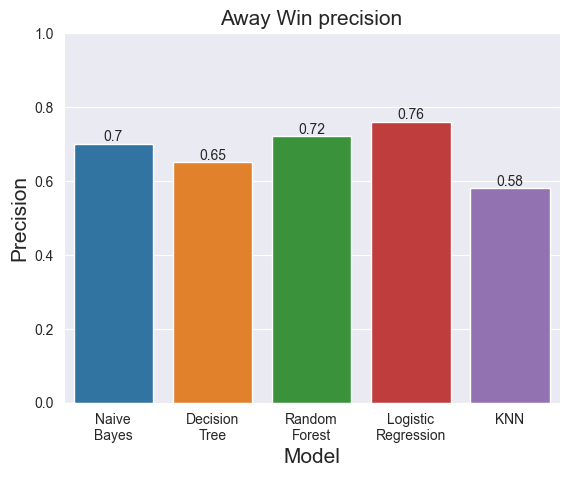

In [58]:
ax = sns.barplot(x=list(c2_precision.keys()), y=list(c2_precision.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Away Win precision",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

### Recall

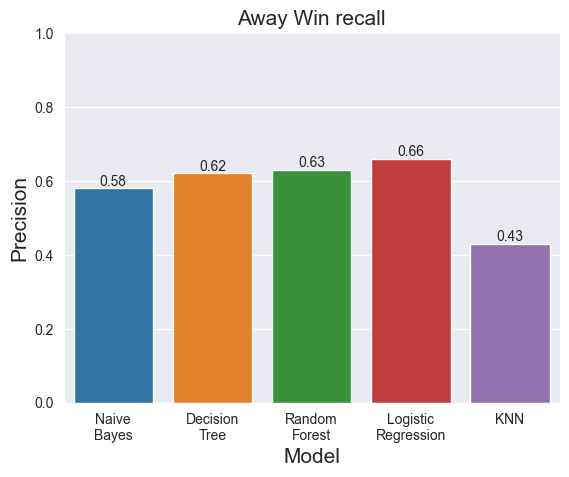

In [59]:
ax = sns.barplot(x=list(c2_recall.keys()), y=list(c2_recall.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Away Win recall",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)

## Tuned models accuracies comparison

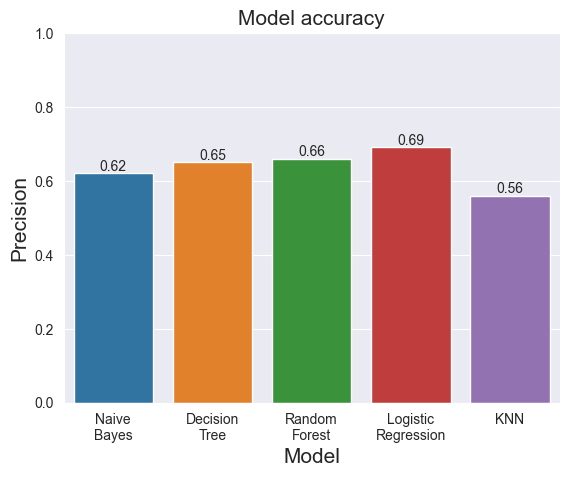

In [60]:
ax = sns.barplot(x=list(tuned_accuracy.keys()), y=list(tuned_accuracy.values()))
for i in ax.containers:
    ax.bar_label(i,)
plt.ylim(0.0,1.0)
plt.title("Model accuracy",fontsize=15)
plt.xlabel("Model", fontsize=15)
plt.ylabel("Precision",fontsize=15)
wrap_labels(ax, 10)